# 第 7 周
3220190783 陈子康

GitHub 地址：https://github.com/czyczk/data-mining-course

本次作业使用 Oakland Crime Statistics 2011 to 2016 数据集。

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import operator
import json
import ast

In [2]:
# Lib config
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

## 1. 导入数据集并合并

> 注：\
2012、2014：没有 `Location`，而是更详细版本的 `Location 1`。将其修改为与其它年份相同的格式。\
2013：列名为 `Location ` 而非 `Location`，需要修改。\
2011、2013、2015、2016：`Location` 列的内容均有前后缀空格，需要移除。

In [3]:
def unify_location_format(dataframe):
    '''
    Modify the values of column "Location" to unify the format of locations.
    '''
    modified_locations = []
    for json_str in dataframe['Location']:
        if json_str != json_str:
            modified_locations.append(float('NaN'))
        else:
            # Build the JSON object / dict from the non-standard string
            location_obj = ast.literal_eval(json_str)
            location_obj['human_address'] = json.loads(location_obj['human_address'])
            # Extract the unified format of location from the JSON object
            location = location_obj['human_address']['address'].strip()
            if not location:
                modified_locations.append(float('NaN'))
            else:
                modified_locations.append(location)
    dataframe['Location'] = pd.Series(modified_locations, index = dataframe.index)

# Oakland crime datasets
data_crime_2011 = pd.read_csv('../Datasets/Oakland_Crime/records-for-2011.csv')
# Remove the leading and trailing whitespaces in values of 'Location'
data_crime_2011['Location'] = data_crime_2011['Location'].str.strip()
# Replace empty values of 'Location' with NaNs
data_crime_2011['Location'] = data_crime_2011['Location'].replace(r'^\s*$', np.nan, regex = True)

data_crime_2012 = pd.read_csv('../Datasets/Oakland_Crime/records-for-2012.csv')
# It has a more detailed version of 'Location' named 'Location 1'. Modify it to align it with the others.
data_crime_2012.rename(columns = {'Location 1': 'Location'}, inplace = True)
unify_location_format(data_crime_2012)

data_crime_2013 = pd.read_csv('../Datasets/Oakland_Crime/records-for-2013.csv')
# Correct the column name from 'Location ' to 'Location'
data_crime_2013.rename(columns = {'Location ': 'Location'}, inplace = True)
# Remove the leading and trailing whitespaces in values of 'Location'
data_crime_2013['Location'] = data_crime_2013['Location'].str.strip()
# Replace empty values of 'Location' with NaNs
data_crime_2013['Location'] = data_crime_2013['Location'].replace(r'^\s*$', np.nan, regex = True)

data_crime_2014 = pd.read_csv('../Datasets/Oakland_Crime/records-for-2014.csv')
# It has a more detailed version of 'Location' named 'Location 1'. Modify it to align it with the others.
data_crime_2014.rename(columns = {'Location 1': 'Location'}, inplace = True)
unify_location_format(data_crime_2014)

data_crime_2015 = pd.read_csv('../Datasets/Oakland_Crime/records-for-2015.csv')
# Remove the leading and trailing whitespaces in values of 'Location'
data_crime_2015['Location'] = data_crime_2015['Location'].str.strip()
# Replace empty values of 'Location' with NaNs
data_crime_2015['Location'] = data_crime_2015['Location'].replace(r'^\s*$', np.nan, regex = True)

data_crime_2016 = pd.read_csv('../Datasets/Oakland_Crime/records-for-2016.csv')
# Remove the leading and trailing whitespaces in values of 'Location'
data_crime_2016['Location'] = data_crime_2016['Location'].str.strip()
# Replace empty values of 'Location' with NaNs
data_crime_2016['Location'] = data_crime_2016['Location'].replace(r'^\s*$', np.nan, regex = True)

data_crime_list = [data_crime_2011, data_crime_2012, data_crime_2013, data_crime_2014, data_crime_2015, data_crime_2016]
data_crime_concatted = None
try:
    data_crime_concatted = pd.concat(data_crime_list, ignore_index = True, verify_integrity = True, sort = False)
except ValueError as e:
    print('ValueError:', e)
data_crime_concatted.reset_index(drop = True, inplace = True)

In [4]:
# There should be no column named 'Location ' and 'Location 1'
assert 'Location ' not in data_crime_concatted.columns
assert 'Location 1' not in data_crime_concatted.columns
# There should be no empty values of 'Location'
assert data_crime_concatted.query('`Location` == ""').shape[0] == 0
assert data_crime_concatted.query('`Location` == "    "').shape[0] == 0
# Empty values of 'Location' should be correctly replaced with NaN and the entry should exist
test_entry = data_crime_concatted.query('`Event Number` == "LOP130104000583"')
assert test_entry.shape[0] == 1
assert test_entry.iloc[0]['Location'] != test_entry.iloc[0]['Location']

## 2. 确认挖掘范围
该数据集可研究事发地点 `Location` 与多个属性的关联。
其中可排除 `Agency`、`Area Id`、`Beat`、`Event Number`、`Zip Codes` 这些与案件无关或每起案件独立的属性。
因为已经提供了 `Incident Type Description` 可供直观观察，故排除冗余信息 `Incident Type Id`；
因为结案时间可能因案件持续多年而与事发时间相关较大，无参考价值，故排除。

还剩下的数值属性有 `Create Time` 和 `Priority`；标称属性有 `Incident Type Description` 和 `Location`。
其中 `Create Time` 为连续的数值属性，在此次分析中将其按季度为粒度划分；
`Priority` 为离散数值属性，且范围不大，可直接使用。

In [5]:
print('"Priority" 最小值为 %i，最大值为 %i。' % (data_crime_concatted.Priority.min(), data_crime_concatted.Priority.max()))

"Priority" 最小值为 0，最大值为 2。


将 `Create Time` 扩展为 `Create Year` 和 `Create Quarter`。

In [6]:
data_crime_concatted['Create Year'] = data_crime_concatted['Create Time'].str[0:4]

quarters = []
for val in data_crime_concatted['Create Time']:
    if val != val:
        quarters.append(float('NaN'))
    else:
        quarters.append(int((int(val[5:7]) + 3) // 4))

data_crime_concatted['Create Quarter'] = pd.Series(quarters, index = data_crime_concatted.index)

## 3. 缺失数据处理
`Create Time` 缺失的有 4 条，由于这几条的其他列均为 NaN，故作删除处理。

In [7]:
print('原有数据条目数：%i。' % data_crime_concatted.shape[0])
print('"Create Time" 缺失条目数：%i。' % data_crime_concatted.query('`Create Time` != `Create Time`').shape[0])
print('这些条目完全不可用，故作删除处理。')
data_crime_concatted.query('`Create Time` != `Create Time`')

原有数据条目数：1046388。
"Create Time" 缺失条目数：4。
这些条目完全不可用，故作删除处理。


,Agency,Create Time,Location,Area Id,Beat,Priority,Incident Type Id,Incident Type Description,Event Number,Closed Time,Zip Codes,Create Year,Create Quarter
180015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
367271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
555498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1046387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
data_crime_pruned = data_crime_concatted.dropna(subset = ["Create Time"], how = 'all')
print('现有数据条目数：%i。' % data_crime_pruned.shape[0])

现有数据条目数：1046384。


`Location` 缺失的条目数量为 296 条，`Incident Type Description` 缺失的条目数量为 388 条。若用众数或推测值来补值可能导致歪曲事实，而缺失数目相较总数目占比很小，将其删除不会太大地影响挖掘出的模式的有效性，故对这些数据作删除处理。

In [9]:
print('"Location" 缺失条目数：%i。' % data_crime_pruned.query('`Location` != `Location`').shape[0])
print('"Incident Type Description" 缺失条目数：%i。' % data_crime_pruned.query('`Incident Type Description` != `Incident Type Description`').shape[0])
data_crime_pruned = data_crime_pruned.dropna(subset = ["Location"], how = 'all')
data_crime_pruned = data_crime_pruned.dropna(subset = ["Incident Type Description"], how = 'all')
print('现有数据条目数：%i。' % data_crime_pruned.shape[0])
data_crime_pruned.reset_index(drop = True, inplace = True)

"Location" 缺失条目数：296。
"Incident Type Description" 缺失条目数：388。
现有数据条目数：1045700。


## 3. 为 FP-Growth 算法准备数据结构与算法

In [10]:
class TreeNode:
    '''
    A class representing a tree node in FP trees.
    '''
    def __init__(self, node_name = None):
        self.__node_name = node_name
        self.__support_count = 0
        self.__parent_node = None
        self.__child_nodes = []
        self.__next_sibling = None
    
    @property
    def node_name(self): return self.__node_name
    @node_name.setter
    def node_name(self, value):
        if self.__node_name != value:
            self.__node_name = value
    
    @property
    def support_count(self): return self.__support_count
    @support_count.setter
    def support_count(self, value):
        if value < 0:
            raise ValueError('`support_count` must be an integer >= 0')
        self.__support_count = value
    
    def incr_support_count(self, value = 1):
        self.__support_count += value
    
    @property
    def parent_node(self): return self.__parent_node
    @parent_node.setter
    def parent_node(self, value):
        if self.__parent_node != value:
            self.__parent_node = value
    
    @property
    def child_nodes(self): return tuple(self.__child_nodes)
    
    def child_node_with_name(self, node_name):
        for node in self.child_nodes:
            if node.node_name == node_name:
                return node
        
        return None
    
    def append_child_node(self, node):
        self.__child_nodes.append(node)
    
    @property
    def next_sibling(self): return self.__next_sibling
    @next_sibling.setter
    def next_sibling(self, value):
        if self.__next_sibling != value:
            self.__next_sibling = value
    
    def print_inorder_traversal(self):
        queue = [self]
        while queue:
            cur = queue.pop(0)
            print(cur.node_name, ':', cur.support_count)
            queue.extend(cur.child_nodes)
    

In [11]:
class Pattern:
    def __init__(self, items, support_count):
        self.__items = items
        self.__support_count = support_count
    
    @property
    def items(self): return tuple(self.__items)
    
    @property
    def support_count(self): return self.__support_count
    
    def __str__(self):
        separator = ' | '
        return str(self.support_count) + separator + separator.join(self.items)

In [12]:
class FPTree:
    def __init__(self, min_support_threshold):
        self.__min_support_threshold = min_support_threshold
        
    @property
    def min_support_threshold(self): return self.__min_support_threshold
    
    def build_header_table(self, trans_entries):
        '''
        Builds a header table from the transaction entries specified.
        The transaction entries should be provided as a list of entries
        in the format of `["columnName1:cellValue1", "columnName2:cellValue2", ...]`.
        Returns a header table.
        '''
        f_1 = [] # Stores nodes with supports above the threshold, sorted by supports in descending order, and then in alphabetical order

        if len(trans_entries) == 0:
            return f_1

        node_map = {}

        for entry in trans_entries:
            # Calculate the support count for each entry in trans_entries
            for item in entry:
                if item not in node_map:
                    # If the item is not in the node map, create a new node and set the support count to 1
                    node = TreeNode(item)
                    node.support_count = 1
                    node_map[item] = node
                else:
                    # If the item is found in the node map, increment the support count of the node
                    node_map[item].incr_support_count()

        for item, node in node_map.items():
            # Put the nodes with supports above min_support_threshold into f_1
            if node.support_count >= self.min_support_threshold:
                f_1.append(node)

        # Sort f_1 by supports in descending order and then in alphabetical order
        f_1.sort(key = lambda i: i.node_name)
        f_1.sort(key = lambda i: i.support_count, reverse = True)
        return f_1
    
    def build_tree(self, trans_entries, f_1):
        f_1_names = []
        for node in f_1:
            f_1_names.append(node.node_name)
        
        root = TreeNode()
        
        for entry in trans_entries:
            pruned_entry = []
            for freq_item in f_1_names:
                if freq_item in entry:
                    pruned_entry.append(freq_item)
            
            sub_tree_root = root
            temp_root = None
            if len(root.child_nodes) != 0:
                while len(pruned_entry) != 0:
                    temp_root = sub_tree_root.child_node_with_name(pruned_entry[0])
                    if temp_root == None:
                        break
                    temp_root.incr_support_count()
                    sub_tree_root = temp_root
                    pruned_entry.pop(0)
            self.add_nodes(sub_tree_root, pruned_entry, f_1)
        
        return root
    
    def add_nodes(self, ancestor, entry, f_1):
        if len(entry) == 0:
            return
        
        while len(entry) > 0:
            item = entry.pop(0)
            leaf_node = TreeNode(item)
            leaf_node.support_count = 1
            leaf_node.parent_node = ancestor
            ancestor.append_child_node(leaf_node)
            
            for freq_node in f_1:
                if freq_node.node_name == item:
                    while freq_node.next_sibling is not None:
                        freq_node = freq_node.next_sibling
                    freq_node.next_sibling = leaf_node
                    break
            
            self.add_nodes(leaf_node, entry, f_1)
    
    def mine(self, trans_entries, post_pattern = [], instant_print = False):
        header_table = self.build_header_table(trans_entries)
        tree_root = self.build_tree(trans_entries, header_table)
        mined_patterns = []
        
        if not tree_root.child_nodes:
            return mined_patterns
        
        if post_pattern:
            for header in header_table:
                if instant_print:
                    print(header.support_count, ' | ', header.node_name, end = '')
                    for i in range(len(post_pattern)):
                        if i == 0:
                            print(' | ', end = '')
                        if i == len(post_pattern) - 1:
                            print(post_pattern[i], end = '')
                        else:
                            print(post_pattern[i], end = ' | ')
                    print()
                pattern_items = [header.node_name]
                pattern_items.extend(post_pattern)
                mined_patterns.append(Pattern(pattern_items, header.support_count))
        
        for header in header_table:
            new_post_pattern = []
            new_post_pattern.append(header.node_name)
            
            if post_pattern:
                for string in post_pattern:
                    new_post_pattern.append(string)
            
            new_trans_entries = []
            back_node = header.next_sibling
            
            while back_node is not None:
                support_count = back_node.support_count
                pre_nodes = []
                parent = back_node
                while True:
                    parent = parent.parent_node
                    if parent.node_name == None or len(parent.node_name) == 0:
                        break
                    pre_nodes.append(parent.node_name)
                while support_count > 0:
                    support_count -= 1
                    new_trans_entries.append(pre_nodes)
                back_node = back_node.next_sibling
            
            mined_patterns.extend(self.mine(new_trans_entries, new_post_pattern, instant_print))
    
        return mined_patterns

## 4. 挖掘

指定相对支持度阈值为 0.0011，相应的绝对支持度阈值即为 1150。

In [13]:
entries_length = data_crime_pruned.shape[0]
min_relative_support_threshold = 0.0011
min_support_threshold = round(entries_length * min_relative_support_threshold)
print('相对支持度阈值：%g' % min_relative_support_threshold)
print('绝对支持度阈值：%g' % min_support_threshold)

相对支持度阈值：0.0011
绝对支持度阈值：1150


先将数据集化为挖掘算法支持的格式。
只挖掘在第 2 节中讨论的列范围：`Location`、`Incident Type Description`、`Create Year`、`Create Quarter`、`Priority`。

In [14]:
trans_entries = []
interested_columns = ['Location', 'Incident Type Description', 'Create Year', 'Create Quarter', 'Priority']

for i, row in data_crime_pruned.iterrows():
    entry = []
    for col_name in interested_columns:
        entry.append('%s:%s' % (col_name, row[col_name]))
    trans_entries.append(entry)


In [15]:
# test_entries = []
# test_event_names = ['LOP110101000084', 'LOP130101000005', 'LOP130109000171', 'LOP130111000885']
# for i, row in data_crime_pruned.query('`Event Number` == "LOP110101000084" or `Event Number` == "LOP130101000005" or `Event Number` == "LOP130109000171" or `Event Number` == "LOP130111000885"').iterrows():
#     entry = []
#     for col_name in interested_columns:
#         entry.append('%s:%s' % (col_name, row[col_name]))
#     test_entries.append(entry)

挖掘得到的所有模式如下（数据条目过多，只展示其中 10 条）：

In [16]:
fp_tree = FPTree(min_support_threshold)
mined_patterns = fp_tree.mine(trans_entries)

for i in range(10):
    print(mined_patterns[i])

289794 | Priority:2.0 | Create Quarter:2.0
284772 | Priority:2.0 | Create Quarter:1.0
239846 | Priority:2.0 | Create Quarter:3.0
84162 | Create Quarter:2.0 | Priority:1.0
77775 | Create Quarter:1.0 | Priority:1.0
69327 | Create Quarter:3.0 | Priority:1.0
150005 | Priority:2.0 | Create Year:2015
67036 | Create Quarter:2.0 | Create Year:2015
62695 | Create Quarter:3.0 | Create Year:2015
62555 | Create Quarter:1.0 | Create Year:2015


此次挖掘将重心放在 `Location` 与 `Incident Type Description` 的关系，试图探讨“某些案发地点多发生某种事件类型”的假设，后文将主要围绕这两者之间的关系进行分析。固将挖掘得到的模式进行筛选，只留下同时包含 `Location` 和 `Incident Type Description` 信息的模式。筛选后的模式如下：

In [17]:
patterns_filtered = []
for pattern in mined_patterns:
    location_included = False
    itd_included = False
    location_included_only = True
    for item in pattern.items:
        if not item.startswith('Location'):
            location_included_only = False
        if item.startswith('Location'):
            location_included = True
            continue
        if item.startswith('Incident Type Description'):
            itd_included = True
            continue
        if location_included and itd_included:
            break
    if location_included and itd_included:
        patterns_filtered.append(pattern)

for pattern in patterns_filtered:
    print(pattern)

1979 | Incident Type Description:ALARM-RINGER | Location:INTERNATIONAL BLVD
1646 | Incident Type Description:911 HANG-UP | Location:INTERNATIONAL BLVD
1456 | Incident Type Description:SECURITY CHECK | Location:INTERNATIONAL BLVD
1943 | Priority:2.0 | Incident Type Description:ALARM-RINGER | Location:INTERNATIONAL BLVD
1646 | Priority:2.0 | Incident Type Description:911 HANG-UP | Location:INTERNATIONAL BLVD
1438 | Priority:2.0 | Incident Type Description:SECURITY CHECK | Location:INTERNATIONAL BLVD
1758 | Incident Type Description:SECURITY CHECK | Location:AV&INTERNATIONAL BLVD
1743 | Priority:2.0 | Incident Type Description:SECURITY CHECK | Location:AV&INTERNATIONAL BLVD
1360 | Incident Type Description:ALARM-RINGER | Location:MACARTHUR BLVD
1235 | Incident Type Description:SECURITY CHECK | Location:MACARTHUR BLVD
1195 | Incident Type Description:911 HANG-UP | Location:MACARTHUR BLVD
1318 | Priority:2.0 | Incident Type Description:ALARM-RINGER | Location:MACARTHUR BLVD
1210 | Priority:

为方便后续置信度的计算，将各单项条目的支持度整理如下。

In [18]:
header_table = fp_tree.build_header_table(trans_entries)
supports_single_item = {}
for node in header_table:
    supports_single_item[node.node_name] = node.support_count

为筛选出的每条模式计算相对支持度、置信度与 lift 如下。

In [19]:
def get_support_of_pattern_without_location_condition(pattern):
    conditions = list(pattern.items)
    index_of_location_condition = -1
    for i, condition in enumerate(conditions):
        if condition.startswith('Location'):
            index_of_location_condition = i
        break
    conditions.pop(i)
    
    matched_patterns = []
    
    if len(conditions) > 1:
        for pattern in mined_patterns:
            condition_all_matched = True
            pattern_items = pattern.items
            for item in pattern_items:
                if item.startswith('Location'):
                    condition_all_matched = False
                    break
            if not condition_all_matched:
                continue
            for condition in conditions:
                if condition not in pattern.items:
                    condition_all_matched = False
                    break
            if not condition_all_matched:
                continue
        matched_patterns.append(pattern)
    else:
        matched_patterns.append(Pattern(None, supports_single_item[conditions[0]]))
    
    if matched_patterns:
        support_sum = 0
        for pattern in matched_patterns:
            support_sum += pattern.support_count
        return support_sum
    
    raise Exception('Pattern without location condition not found.')

locations = []
itds = []
priorities = []
supports = []
relative_supports = []
confidences = []
lifts = []

for pattern in patterns_filtered:
    support_count = pattern.support_count
    supports.append(pattern.support_count)
    relative_supports.append(support_count / entries_length)
    location = None
    is_priority_available = False
    
    for item in pattern.items:
        if item.startswith('Location'):
            location = item.split(':')[1]
            locations.append(location)
        elif item.startswith('Priority'):
            priorities.append(item.split(':')[1])
            is_priority_available = True
        elif item.startswith('Incident'):
            itds.append(item.split(':')[1])
    
    if not is_priority_available:
        priorities.append(float('NaN'))
    
    # Calculate the confidence
    support_location = supports_single_item['Location:' + location]
    confidence = pattern.support_count / support_location
    confidences.append(confidence)
    
    # Calculate the lift
    support_of_pattern_without_location_condition = get_support_of_pattern_without_location_condition(pattern)
    lift = support_count / (support_location * support_of_pattern_without_location_condition)
    lifts.append(lift)

df_patterns_filtered = pd.DataFrame(list(zip(locations, itds, priorities, supports, relative_supports, confidences, lifts)),
                                    columns = ['Location', 'Incident Type Description', 'Priority', 'Support', 'Relative Support', 'Confidence', 'Lift'])

In [20]:
df_patterns_filtered

,Location,Incident Type Description,Priority,Support,Relative Support,Confidence,Lift
0,INTERNATIONAL BLVD,ALARM-RINGER,NaN,1979,0.001893,0.095447,0.000005
1,INTERNATIONAL BLVD,911 HANG-UP,NaN,1646,0.001574,0.079387,0.000004
2,INTERNATIONAL BLVD,SECURITY CHECK,NaN,1456,0.001392,0.070223,0.000003
3,INTERNATIONAL BLVD,ALARM-RINGER,2.0,1943,0.001858,0.093711,0.000071
4,INTERNATIONAL BLVD,911 HANG-UP,2.0,1646,0.001574,0.079387,0.000060
5,INTERNATIONAL BLVD,SECURITY CHECK,2.0,1438,0.001375,0.069355,0.000053
6,AV&INTERNATIONAL BLVD,SECURITY CHECK,NaN,1758,0.001681,0.098267,0.000005
7,AV&INTERNATIONAL BLVD,SECURITY CHECK,2.0,1743,0.001667,0.097429,0.000074
8,MACARTHUR BLVD,ALARM-RINGER,NaN,1360,0.001301,0.079088,0.000005
9,MACARTHUR BLVD,SECURITY CHECK,NaN,1235,0.001181,0.071819,0.000004


## 5. 分析

挖掘结果中，不乏有 `Priority` 与 `Create Quarter` 或 `Create Quarter` 与 `Create Year` 这样的关联规则，且它们拥有很高的支持度。但由于这些结果没有现实意义，予以排除。

本篇工作主要围绕 `Location` 与 `Incident Type Description` 的关系进行讨论，附带考察其他列。然而，筛选必须包含 `Location` 与 `Incident Type Description` 的模式条目后，所剩下的模式支持度不是太高，且均无法与 `Create Year`、`Create Quarter` 产生较高的关联。

进一步对其置信度与 lift 进行分析后，发现案发地点与事件类型相关性弱，无法支持“某些案发地点常发生某种事件类型”的假设。

## 6. 可视化
以直方图形式展示频繁模式的绝对支持度的分布。

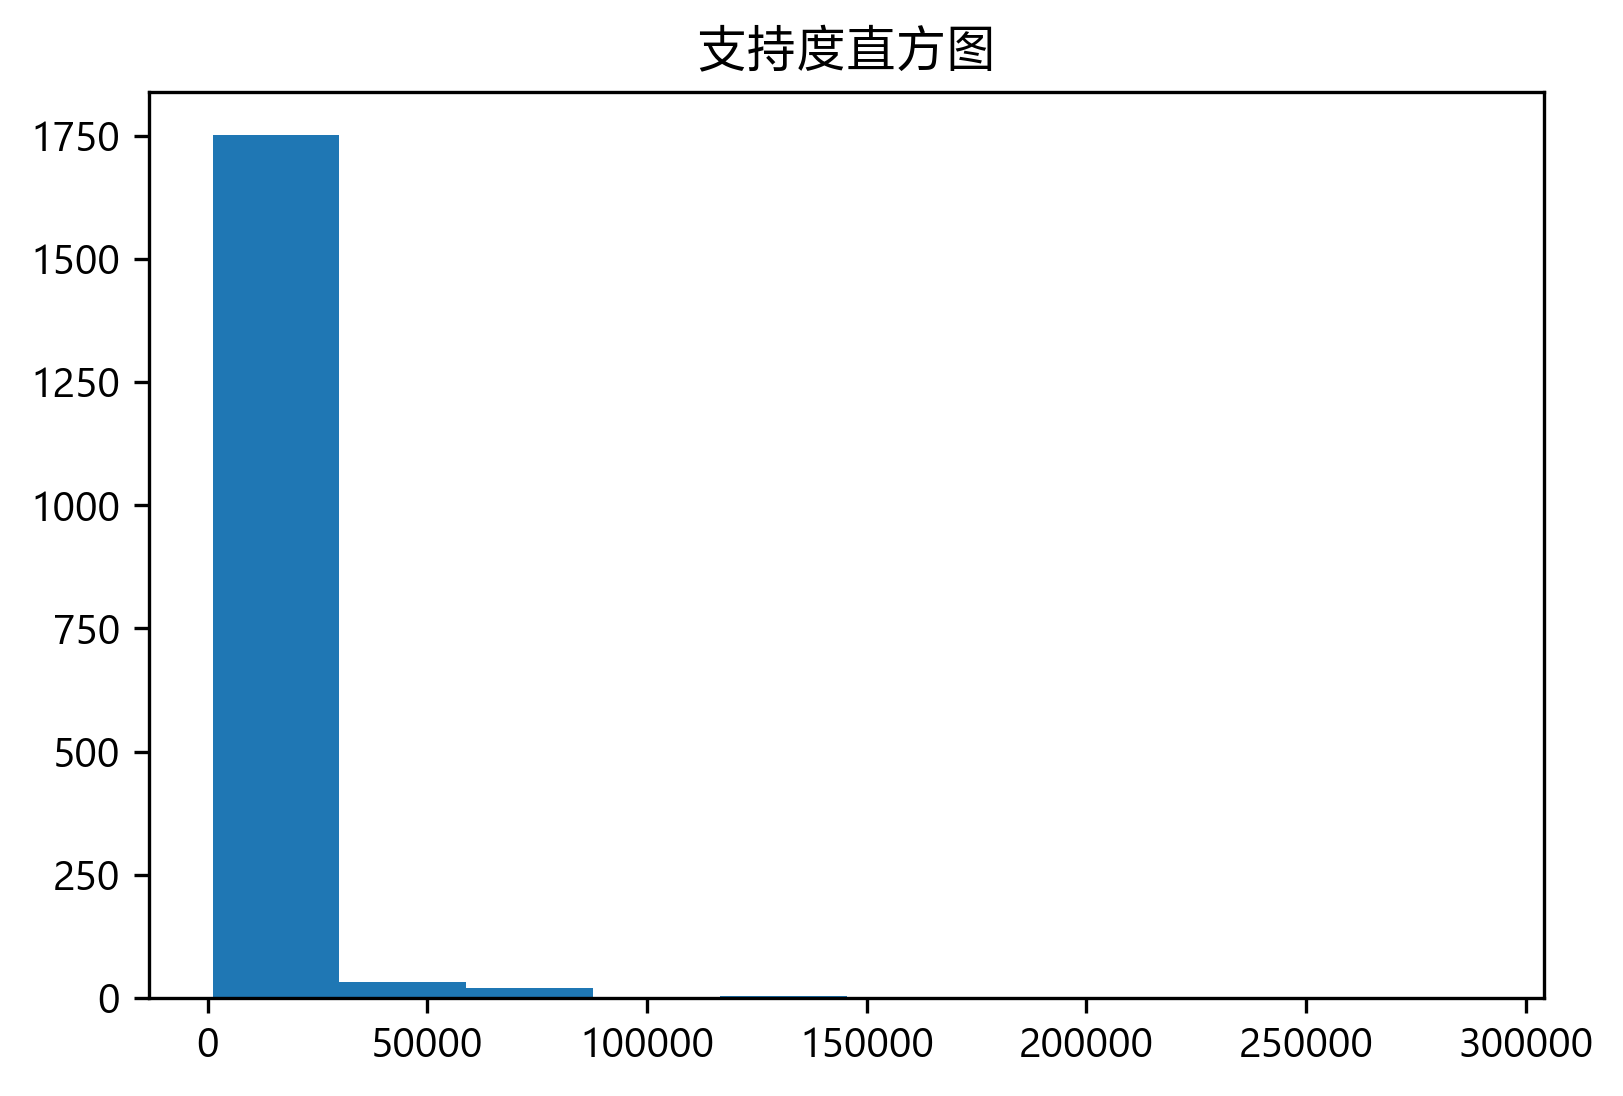

In [21]:
supports = [pattern.support_count for pattern in mined_patterns]
plt.title('支持度直方图')
plt.hist(supports, bins = 10)
plt.show()

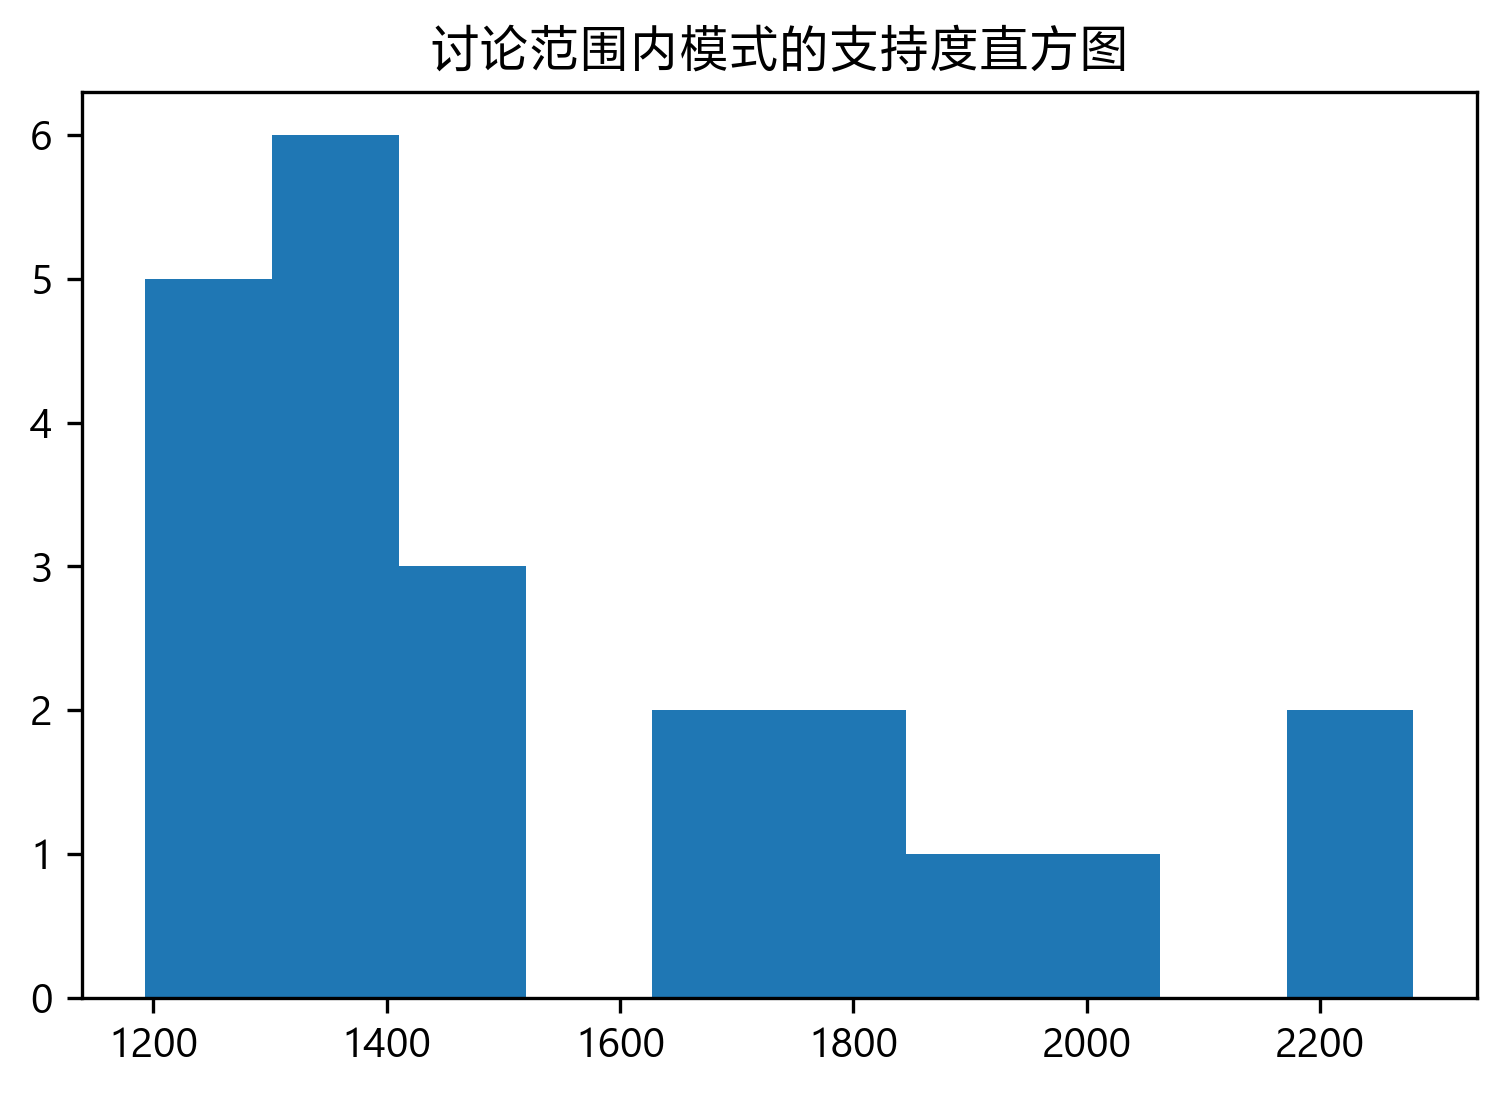

In [24]:
supports_filtered = [pattern.support_count for pattern in patterns_filtered]
plt.title('讨论范围内模式的支持度直方图')
plt.hist(supports_filtered, bins = 10)
plt.show()

以盒图形式展示频繁模式的绝对支持度的分布。

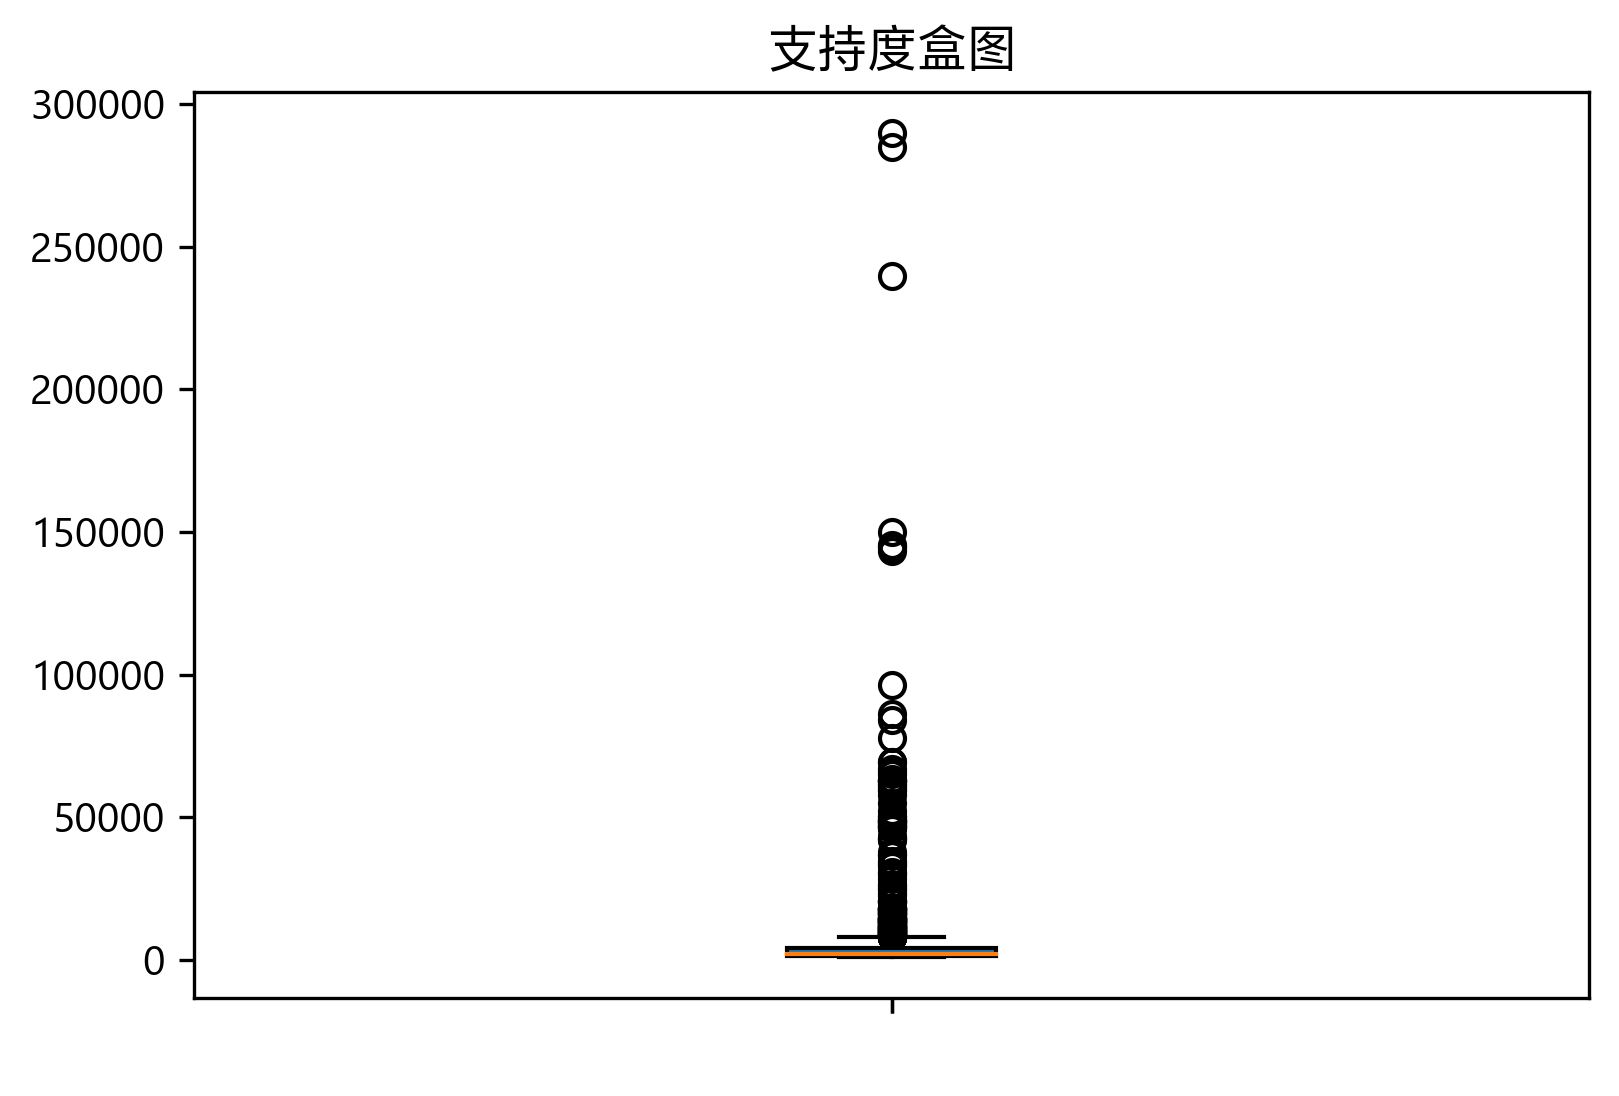

In [27]:
plt.xticks([x+1 for x in range(len(supports))], ' ')
plt.title('支持度盒图')
plt.boxplot(supports, notch = False, sym = 'o', vert = True, patch_artist = True)
plt.show()

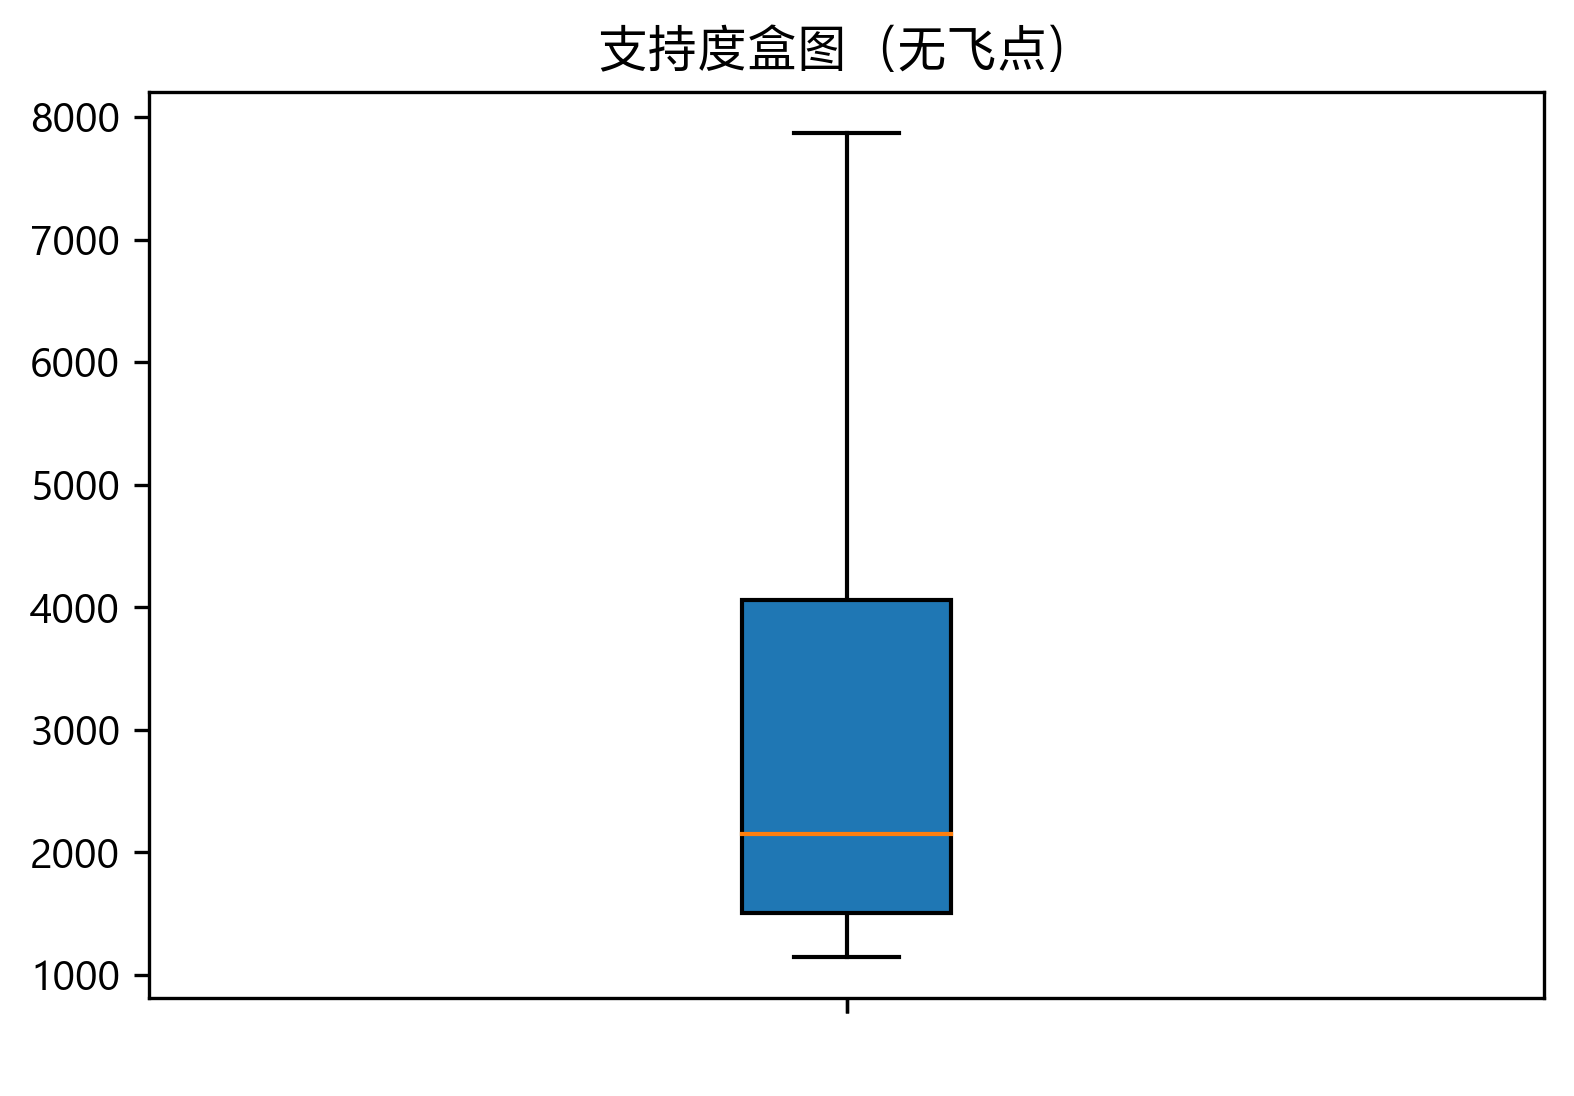

In [29]:
plt.xticks([x+1 for x in range(len(supports))], ' ')
plt.title('支持度盒图（无飞点）')
plt.boxplot(supports, notch = False, sym = 'o', vert = True, patch_artist = True, showfliers = False)
plt.show()

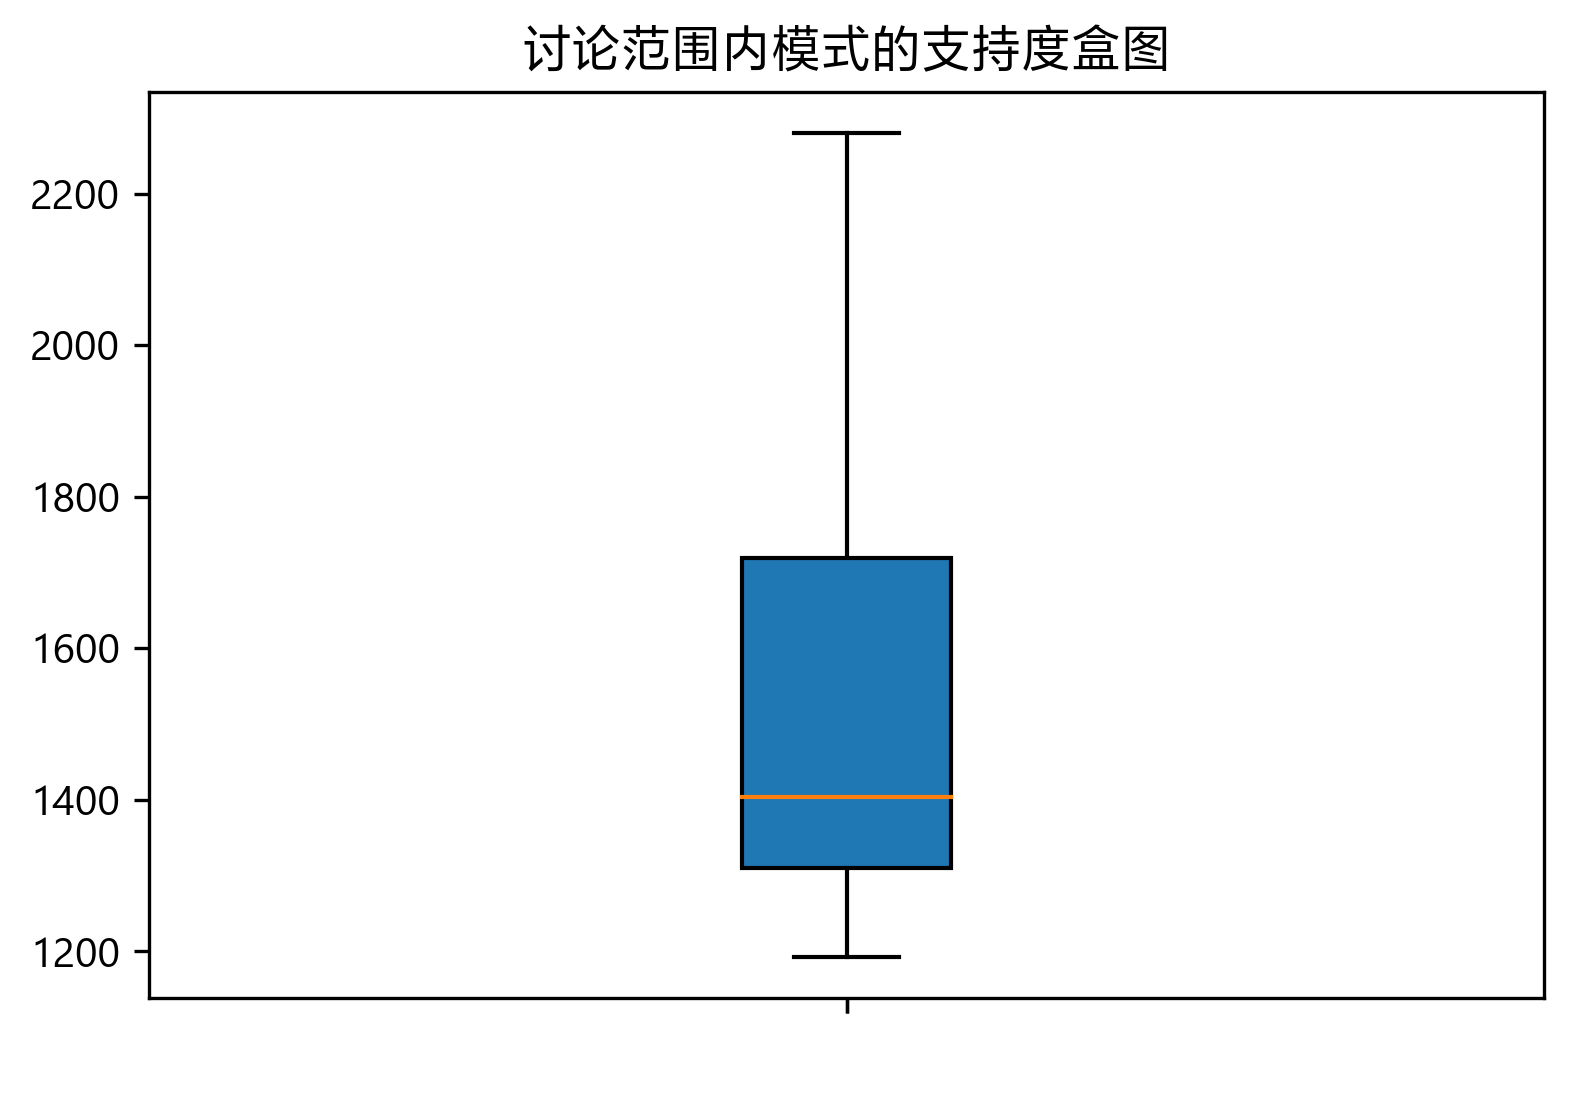

In [30]:
plt.xticks([x+1 for x in range(len(supports_filtered))], ' ')
plt.title('讨论范围内模式的支持度盒图')
plt.boxplot(supports_filtered, notch = False, sym = 'o', vert = True, patch_artist = True)
plt.show()